# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
import sys
sys.path.insert(0, '../')
import scoring

# Import Data
## Raw Data

In [2]:
data = pd.read_csv('demo_data/DemoTgt.csv', sep = ',', decimal = '.', encoding = 'utf-8',
                   low_memory=False, keep_default_na=False, na_values = [''])

## Define column with time
If we want to use only certain time period for the target analysis, this should be the "month" column that will be used to define this period.

In [3]:
col_time = 'id'

## Define columns with predictors

In [4]:
from scoring.db import get_optimal_numerical_type
cols_pred = list(pd.read_csv(r'demo_data/TgtAnaPredList.CSV', sep = ',', decimal = '.', 
                   encoding = 'windows-1251', low_memory = False, header = None)[0])

column_types = list(zip(data[cols_pred].columns,data[cols_pred].dtypes))
cols_pred_cat = [col_name for col_name,dtype in column_types if dtype.name == 'category' or dtype.name == 'object']
cols_pred_num = [col_name for col_name,dtype in column_types if ('float' in dtype.name) or ('int' in dtype.name)]

# ALTERNATIVELY, DEFINE THE PREDICTOR NAMES MANUALLY

# cols_pred_num = ["Numerical_1","Numerical_2","Numerical_3","Numerical_4","Numerical_5", ]
# cols_pred_cat = ["Categorical_1", "Categorical_2","Categorical_3","Categorical_4","Categorical_5"]

for name, col in data.iteritems():
    if name in cols_pred_num:
        if not pd.api.types.is_numeric_dtype(col.values.dtype):
            try:
                col.astype(np.number)
                data[name] = col.astype(get_optimal_numerical_type(col))
            except:
                print('Column {0} couldn\'t be converted to numerical. Will be used as categorical.'.format(name))
                cols_pred_num.remove(name)
                cols_pred_cat.append(name)
    
    if name in cols_pred_cat:
        if col.dtype.name not in {'object', 'string', 'category'}:
            try:
                data[name] = col.astype('category')
            except:
                data[name] = col.astype(str)

print('List of numerical predictors: [{0}]\n'.format(len(cols_pred_num)))
for col in cols_pred_num:
    print(str.ljust(col, 35), data[col].dtype.name)

print('-'*100)
print()
print('List of categorical predictors: [{0}]\n'.format(len(cols_pred_cat)))
for col in cols_pred_cat:
    print(str.ljust(col, 35), data[col].dtype.name)

List of numerical predictors: [5]

x0                                  float64
x1                                  float64
x2                                  float64
x3                                  float64
x4                                  float64
----------------------------------------------------------------------------------------------------

List of categorical predictors: [2]

s0                                  object
s1                                  object


## Train/Valid/Test split
You can also add HOOT and OOT samples if you want to cut too old or too new data out from the analysis.

In [5]:
from scoring.data_manipulation import data_sample_time_split

data['data_type'] = data_sample_time_split(data, 
                           time_column = col_time,
                           splitting_points = [],
                           sample_sizes = [[ 0.4   , 0.3   , 0.3  ]],
                           sample_names = [['train','valid','test']],
                           #stratify_by_columns = [col_target],
                           random_seed = 1234)

train   4,000 rows
valid   3,000 rows
test    3,000 rows


In [6]:
train_mask = (data['data_type'] == 'train')
valid_mask = (data['data_type'] == 'valid')
test_mask = (data['data_type'] == 'test')

# Targets to be analyzed
Targets should be defined
 - either in a list of dictionaries as shown below. Each dictionary should consist of two entries: 'target' with target name and 'base' with corresponding base name.
 - or in a csv with two unnamed columns, first with target names and second with corresponding base names.

**If bases do not exist in the data set, you will need to add them manually before proceeding!**

In [7]:
# DEFINING TARGET AS DICTIONARY
target_definitions = [
    {'target':'y0', 'base':'b0'},
    {'target':'y1', 'base':'b1'},
    {'target':'y2', 'base':'b2'},
    {'target':'y3', 'base':'b3'},
    {'target':'y4', 'base':'b4'},
]

# LOADING DEFINITION FROM A FILE
target_definitions = pd.read_csv(r'demo_data/TgtAnaTargetDef.CSV', sep = ',', decimal = '.', 
                   encoding = 'windows-1251', low_memory = False, header = None)
target_definitions.columns = ['target','base']
target_definitions = target_definitions.to_dict('records')

# Target selection using XGBoost
Helps to choose the best targets if from multiple candidates. Use fit() method:
 - for each target, it trains xgboost model (all categorical predictors are grouped and WOE-transformed before the boosting) using training and validation (for stopping) set
 - then Gini is measured for each such model using all possible targets and testing datasets

So at the end, we have #targets x #targets Gini values in a matrix. Then the analyst can choose which target (for training) is the best (usually because the Gini of its model is high also for the other targets)

In [8]:
from scoring.target_selection import XgbTargetSelection

xgbsel = XgbTargetSelection(xgb_params=None, 
                            num_boost_round=500, 
                            early_stopping_rounds=25, 
                            group_count=5, 
                            min_samples_cat=200)
ginisdf = xgbsel.fit(data_train = data[train_mask],
                     data_valid = data[valid_mask],
                     data_test = data[test_mask],
                     target_definitions = target_definitions, 
                     cols_pred_num = cols_pred_num, 
                     cols_pred_cat = cols_pred_cat)

Training Grouping for target y0
Transforming Grouping for target y0
Transforming Booster for target y0
Training Grouping for target y1
Transforming Grouping for target y1
Transforming Booster for target y1
Training Grouping for target y2
Transforming Grouping for target y2
Transforming Booster for target y2
Training Grouping for target y3
Transforming Grouping for target y3
Transforming Booster for target y3
Training Grouping for target y4
Transforming Grouping for target y4
Transforming Booster for target y4


In [9]:
ginisdf

GINI TARGET,y0,y1,y2,y3,y4
TRAIN TARGET,,,,,
y0,0.318158,0.343994,0.283661,0.342547,0.408100
y1,0.330705,0.354319,0.293678,0.353597,0.425227
y2,0.314001,0.332662,0.274530,0.334371,0.402236
y3,0.312017,0.338539,0.277836,0.340333,0.408975
y4,0.325579,0.354840,0.291619,0.346614,0.419946


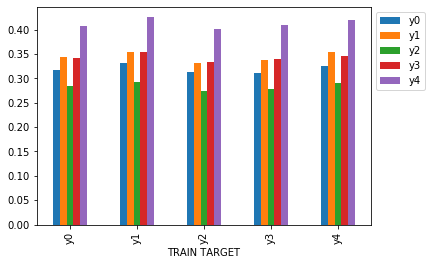

In [10]:
ginisdf.plot.bar()
plt.legend(bbox_to_anchor=(1,1))
plt.show()